In [1]:
import pathlib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
# No info messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [3]:
# Limit GPU memory growth for RTX cards
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Enable FP16 on RTX cards for faster processing
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_policy(policy)

1 Physical GPUs, 1 Logical GPUs


In [4]:
from tensorflow.keras import datasets, layers, models

Our dataset directory should contain 2 folders inside of it: *bad* and *healthy*. Those 2 are going to be our final classes, stored under `CLASS_NAMES`.

In [5]:
data_dir = os.path.join("dataset")
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob("*/*.JPG")))

# Our dataset folder should contain subfolders with the final classes that we want,
# such as "good" and "bad". Those classes will be saved under CLASS_NAMES
CLASS_NAMES = np.array([item.name for item in data_dir.glob("*")])
IMG_HEIGHT = 256
IMG_WIDTH = 256

The 2 variables bellow define the speed and memory usage during the use of this notebook.

The **bigger** the BATCH_SIZE, the faster the code will run, but at the cost of more RAM usage. A value of 1 is acceptable and should provide a low enough RAM usage.

SUFFLE_RATIO defines in how many "pieces" we will split the data while shuffling. Using a value of 1 makes us use our entire dataset at once to shuffle, giving us a perfect shuffle between all items. **Incresing** this value will make our data less mixed, but will save some RAM.

In [ ]:
BATCH_SIZE = 128
SHUFFLE_RATIO = 1

In [6]:
# Loads the actual image from the path given in filename
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Defines the shape of our data, otherwise tf will set it as (None,None)
    image.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))

    return image, label

In [7]:
# Used to augment our data by flipping it randomly
def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    return image, label

What we want to do here is to:

1. Have lists containing the paths for our good and bad images
2. Another lists, but this time for the labels
3. For our validation data:
    1. Take 20% of each class in different lists
    2. Merge those lists together for our final dataset
4. For our training data:
    1. Take 80% of each class in different lists for each class
    2. Balance out the minority class
    3. Marge both lists together for our final training dataset

In [8]:
# lists containing the directory for each file
filenames_bad = []
filenames_good = []
# lists containing the label for each file
labels_bad = []
labels_good = []

# Fills our bad list
for a in os.listdir(cur_dir := os.path.join(data_dir, CLASS_NAMES[0])):
    filenames_bad.append(os.path.join(cur_dir, a))
    labels_bad.append(0)
    
# Fills our good list
for a in os.listdir(cur_dir := os.path.join(data_dir, CLASS_NAMES[1])):
    filenames_good.append(os.path.join(cur_dir, a))
    labels_good.append(1)

In [9]:
# Takes 20% of our data as validation data
val_data = filenames_bad[int(len(filenames_bad) * 0.8):]
val_data_temp = filenames_good[int(len(filenames_good) * 0.8):]
val_labels = labels_bad[int(len(labels_bad) * 0.8):]
val_labels_temp = labels_good[int(len(labels_good) * 0.8):]

# Concatenates both good and bad lists
val_data.extend(val_data_temp)
val_labels.extend(val_labels_temp)

# Creates our tf.Dataset and loads the actual images instead of paths
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.map(parse_function, num_parallel_calls=4)

In [10]:
# Takes 80% of our data as train data
train_data_b = filenames_bad[:int(len(filenames_bad) * 0.8)]
train_data_g = filenames_good[:int(len(filenames_good) * 0.8)]
train_labels_b = labels_bad[:int(len(labels_bad) * 0.8)]
train_labels_g = labels_good[:int(len(labels_good) * 0.8)]

# Creates our tf.Dataset and loads the actual images instead of paths
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_g, train_labels_g))
train_dataset = train_dataset.map(parse_function, num_parallel_calls=4)

# The ration between our good and bad data for balance reasons
ratio = int(len(train_data_b)/len(train_data_g))

# Augments our data RATIO times
temp = train_dataset
for i in range(ratio):
    train_dataset = train_dataset.concatenate(temp.map(train_preprocess, num_parallel_calls=4))

# Temp dataset with our bad data
temp = tf.data.Dataset.from_tensor_slices((train_data_b, train_labels_b))
temp = temp.map(parse_function, num_parallel_calls=4)

# Concatenates both datasets for our final balanced dataset
train_dataset = train_dataset.concatenate(temp)

Let's see if everything worked out as we wanted by plotting some of our data

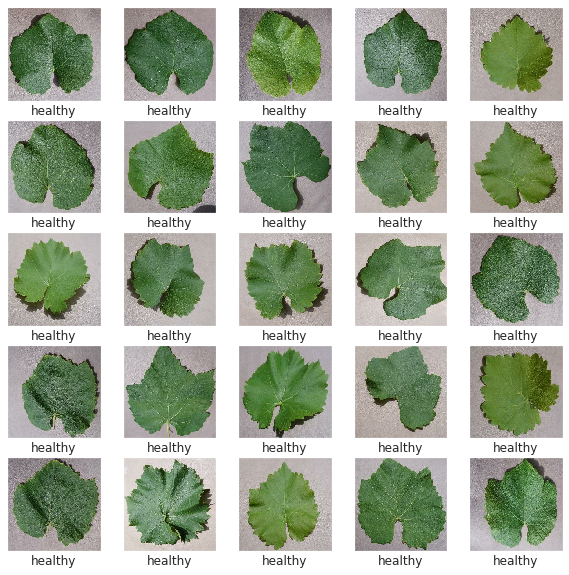

In [11]:
plt.figure(figsize=(10,10))
temp = train_dataset.take(25)
temp = temp.as_numpy_iterator()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = next(temp)
    image, label = np.array(image), np.array(label)
    plt.imshow(image.astype(np.float32), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(CLASS_NAMES[label])
plt.show()

In [12]:
# Sizes of our datasets
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()

# Batch sizes
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Shuffles our dataset. A SHUFFLE_RATIO of 1 is needed for a perfect shuffle
train_dataset = train_dataset.shuffle(int(train_size/SHUFFLE_RATIO))
val_dataset = val_dataset.shuffle(int(val_size/SHUFFLE_RATIO))

# Enabled prefetch so our GPU won't be starved in between epochs
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

This model is based on ResNet, which can be seen [here](https://www.researchgate.net/figure/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be_fig3_331364877). We will modify its input layer and add a classifier at its end to suit our needs.

In [13]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
model = models.Sequential()

ResNet = ResNet50V2(include_top=False, input_shape=(256,256,3))

# Freeze all of the 190 layers of resnet
for layer in ResNet.layers:
    layer.trainable = False
model.add(ResNet)    
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 131073    
Total params: 23,695,873
Trainable params: 131,073
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
# Let's define our early stop and gc callbacks
# The gc is needed in order to keep our RAM free
import gc

class MemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        gc.collect()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

import time
start = time.time()

history = model.fit(train_dataset , epochs=100, batch_size=BATCH_SIZE,
                    validation_data=val_dataset, callbacks=[MemoryCallback(),early_stop])
end = time.time() - start

print("Took ", end, "s")

Epoch 1/100
47/47 [==============================] - 14s 302ms/step - loss: 1.4061 - accuracy: 0.7154 - val_loss: 0.0413 - val_accuracy: 0.9877
Epoch 2/100
47/47 [==============================] - 11s 238ms/step - loss: 0.0736 - accuracy: 0.9741 - val_loss: 0.0186 - val_accuracy: 0.9963
Epoch 3/100
47/47 [==============================] - 11s 240ms/step - loss: 0.0401 - accuracy: 0.9864 - val_loss: 0.0102 - val_accuracy: 0.9988
Epoch 4/100
47/47 [==============================] - 11s 243ms/step - loss: 0.0257 - accuracy: 0.9931 - val_loss: 0.0083 - val_accuracy: 0.9975
Epoch 5/100
47/47 [==============================] - 11s 238ms/step - loss: 0.0156 - accuracy: 0.9955 - val_loss: 0.0060 - val_accuracy: 0.9988
Epoch 6/100
47/47 [==============================] - 11s 238ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.0077 - val_accuracy: 0.9975
Epoch 7/100
47/47 [==============================] - 11s 238ms/step - loss: 0.0102 - accuracy: 0.9978 - val_loss: 0.0049 - val_accuracy:

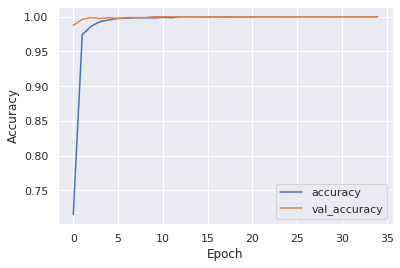

NameError: name 'test_data' is not defined

In [17]:
plt.close()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_data,  test_label, verbose=2)
print(test_acc)

In [ ]:
model.save('model_resnet.h5')